In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

#text processing
import re
import string
import nltk
from gensim import corpora, models, similarities 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#LDA
import gensim
import pyLDAvis.gensim

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:972: DeprecationWarning: invalid escape sequence \s
  """
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:1186: DeprecationWarning: invalid escape sequence \s
  """
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\t_sne.py:420: DeprecationWarning: invalid escape sequence \s
  """


In [2]:
#read the csv file with scraped data
news_data=pd.read_csv('news_output.csv',error_bad_lines=False)
news_data['Title'] = news_data['Title'].astype(str)
news_data['Text'] = news_data['Text'].astype(str)
news_data.head()

,siteName,Title,Authors,Text,Link,Published_Date
0,nytimes,What Motivates Mitch McConnell?,[],What Motivates Mitch McConnell? The Senate maj...,https://www.nytimes.com/2019/02/05/podcasts/th...,2019-02-05 00:00:00
1,nytimes,Diversity in Big Law and the Attack on Jussie ...,[],"In many ways, the story isn’t about one law fi...",https://www.nytimes.com/2019/02/02/us/jussie-s...,2019-02-02 00:00:00
2,nytimes,Trump Inaugural Committee Ordered to Hand Over...,[],Escalating one of the investigations into Pres...,https://www.nytimes.com/2019/02/04/us/politics...,2019-02-04 00:00:00
3,nytimes,Trump Once Said Power Was About Instilling Fea...,[],“It is a common trait among those who ran priv...,https://www.nytimes.com/2019/02/04/us/politics...,2019-02-04 00:00:00
4,nytimes,Path to Trump’s Border Wall Narrows as Republi...,[],"“To every Republican, if you don’t stand behin...",https://www.nytimes.com/2019/02/04/us/politics...,2019-02-04 00:00:00


In [3]:
def initial_clean(text):
    """
    Function to clean text-remove punctuations, lowercase text etc.
    
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')
stop_words.extend(['news', 'say','use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do','took', 
                   'done', 'try', 'many', 'some','nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 
                   'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line','even', 'also', 'may', 'take', 'come', 'new','said', 'like','people'])
def remove_stop_words(text):
    """
    Function to remove all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text


In [4]:
def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))

In [5]:
# clean text and title and create new column "tokenized"
import time
t1 = time.time()
news_data['tokenized_tile'] = news_data['Title'].apply(apply_all) 
t2 = time.time()
print("Time to clean and tokenize", len(news_data), "articles:", (t2-t1)/60, "min")

Time to clean and tokenize 347 articles: 0.0035571614901224774 min


## LDA on news Titles

In [6]:
#create a Gensim dictionary from the tokenized titles
titles = news_data['tokenized_tile']
dictionary = corpora.Dictionary(titles)
#removing extremes 
dictionary.filter_extremes(no_below=1, no_above=0.8)
#convert the dictionary to a bag of words corpus 
corpus = [dictionary.doc2bow(title) for title in titles]

In [19]:
#LDA
ldamodel_title = gensim.models.ldamodel.LdaModel(corpus, num_topics = 15, id2word=dictionary, passes=15)
ldamodel_title.save('model.gensim')
topics = ldamodel_title.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.003*"felt" + 0.003*"mitch" + 0.002*"fund" + 0.002*"mcconnel"')
(1, '0.002*"jei" + 0.002*"money" + 0.002*"secur" + 0.002*"kick"')
(2, '0.005*"mitch" + 0.003*"fund" + 0.003*"bring" + 0.003*"senat"')
(3, '0.002*"separ" + 0.002*"neg" + 0.002*"around" + 0.002*"year"')
(4, '0.003*"ambigu" + 0.003*"economi" + 0.002*"highestrank" + 0.002*"big"')
(5, '0.003*"fund" + 0.003*"interest" + 0.002*"case" + 0.002*"articlebut"')
(6, '0.003*"edit" + 0.002*"character" + 0.002*"better" + 0.002*"class"')
(7, '0.002*"texa" + 0.002*"secur" + 0.002*"money" + 0.002*"multipl"')
(8, '0.013*"anecdot" + 0.013*"allwhit" + 0.010*"mitch" + 0.003*"benefit"')
(9, '0.003*"fund" + 0.002*"felt" + 0.002*"spread" + 0.002*"inact"')
(10, '0.006*"felt" + 0.004*"rachel" + 0.004*"mitch" + 0.003*"engineersand"')
(11, '0.003*"candid" + 0.003*"generalto" + 0.002*"someth" + 0.002*"bigger"')
(12, '0.004*"felt" + 0.002*"hungrili" + 0.002*"crimin" + 0.002*"secur"')
(13, '0.005*"year" + 0.004*"two" + 0.003*"crisi" + 0.003*"turn"')

In [21]:
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV

# Visualizing topics in article title

In [8]:
lda_viz = gensim.models.ldamodel.LdaModel.load('model.gensim')
lda_display = pyLDAvis.gensim.prepare(lda_viz, corpus, dictionary, sort_topics=True)
pyLDAvis.display(lda_display)


###### Saliency: a measure of how much the term tells you about the topic.
###### Relevance: a weighted average of the probability of the word given the topic and the word given the topic normalized by the probability of the topic.
###### The size of the bubble measures the importance of the topics, relative to the data.

## Dominant topics in articles

In [9]:
#combining text and title into a single column
news_data["title_text"] = news_data["Title"] + news_data["Text"]

# clean create new column "tokenized"
t1 = time.time()
news_data['tokenized_title_text'] = news_data['title_text'].apply(apply_all) 
t2 = time.time()
print("Time to clean and tokenize", len(news_data), "articles:", (t2-t1)/60, "min")

##create a Gensim dictionary from the tokenized titles
combined = news_data['tokenized_title_text']
dictionary = corpora.Dictionary(combined)
#removing extremes 
dictionary.filter_extremes(no_below=1, no_above=0.8)
#convert the dictionary to a bag of words corpus 
corpus_combined = [dictionary.doc2bow(combine) for combine in combined]


Time to clean and tokenize 347 articles: 0.10437081654866537 min


In [10]:
#LDA
ldamodel_combined = gensim.models.ldamodel.LdaModel(corpus_combined, num_topics = 20, id2word=dictionary, passes=15)
ldamodel_combined.save('model_combined.gensim')
topics = ldamodel_combined.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.008*"medoff" + 0.007*"stahl" + 0.005*"one" + 0.004*"nairobi"')
(1, '0.011*"selbe" + 0.008*"china" + 0.008*"wertheim" + 0.006*"chines"')
(2, '0.020*"satellit" + 0.013*"martin" + 0.008*"cardillo" + 0.007*"planet"')
(3, '0.012*"shark" + 0.009*"fin" + 0.006*"hong" + 0.006*"kong"')
(4, '0.018*"ocasiocortez" + 0.013*"alexandria" + 0.010*"cooper" + 0.007*"democrat"')
(5, '0.006*"trump" + 0.005*"us" + 0.005*"govern" + 0.005*"year"')
(6, '0.015*"neeson" + 0.007*"kill" + 0.007*"black" + 0.005*"dubai"')
(7, '0.008*"franci" + 0.008*"pope" + 0.006*"year" + 0.006*"one"')
(8, '0.012*"dog" + 0.009*"flight" + 0.008*"food" + 0.008*"attend"')
(9, '0.010*"video" + 0.010*"shark" + 0.006*"fiber" + 0.006*"health"')
(10, '0.008*"qatar" + 0.008*"uae" + 0.005*"cup" + 0.004*"attack"')
(11, '0.016*"trump" + 0.011*"committe" + 0.009*"presid" + 0.007*"support"')
(12, '0.012*"trump" + 0.010*"presid" + 0.006*"state" + 0.006*"time"')
(13, '0.009*"maduro" + 0.008*"venezuela" + 0.007*"presid" + 0.007*"launch"')
(

In [11]:
#visualizing topics
lda_viz_combined = gensim.models.ldamodel.LdaModel.load('model_combined.gensim')
lda_display_combined = pyLDAvis.gensim.prepare(lda_viz_combined, corpus, dictionary, sort_topics=True)
pyLDAvis.display(lda_display_combined)


### Dominant Topic in each article

In [12]:
def dominant_topic(ldamodel, corpus, texts):
    # Function to find the dominant topic in each article
    sent_topics_df = pd.DataFrame()

    # Get main topic in each article
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each article
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num,topn=4)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


In [13]:
df_dominant_topic = dominant_topic(ldamodel=ldamodel_title, corpus=corpus, texts=news_data['Title'])
df_dominant_topic['Text'] = news_data['Text']
df_dominant_topic['Link'] = news_data['Link']
df_dominant_topic.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Title,Text,Link
0,8.0,0.7667,"virginia, us, opinion, top",What Motivates Mitch McConnell?,What Motivates Mitch McConnell? The Senate maj...,https://www.nytimes.com/2019/02/05/podcasts/th...
1,12.0,0.8667,"us, say, russia, fox",Diversity in Big Law and the Attack on Jussie ...,"In many ways, the story isn’t about one law fi...",https://www.nytimes.com/2019/02/02/us/jussie-s...
2,11.0,0.8963,"trump, world, inaugur, feder",Trump Inaugural Committee Ordered to Hand Over...,Escalating one of the investigations into Pres...,https://www.nytimes.com/2019/02/04/us/politics...
3,13.0,0.8667,"presid, trump, north, safe",Trump Once Said Power Was About Instilling Fea...,“It is a common trait among those who ran priv...,https://www.nytimes.com/2019/02/04/us/politics...
4,2.0,0.9067,"state, trump, union, border",Path to Trump’s Border Wall Narrows as Republi...,"“To every Republican, if you don’t stand behin...",https://www.nytimes.com/2019/02/04/us/politics...


In [14]:
topic_group = df_dominant_topic.groupby('Dominant_Topic').size()
topic_group = topic_group.to_frame(name='count').reset_index()
topic_group

,Dominant_Topic,count
0,0.0,20
1,1.0,24
2,2.0,33
3,3.0,26
4,4.0,20
5,5.0,28
6,6.0,28
7,7.0,29
8,8.0,25
9,9.0,14


## Plot of article distribution by dominant topic

In [15]:
# Top 4 Keywords for each Topic
topic_top4words = [(i, topic) for i, topics in ldamodel_combined.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 4]
df_top4words_stacked = pd.DataFrame(topic_top4words, columns=['topic_id', 'words'])
df_top4words = df_top4words_stacked.groupby('topic_id').agg(', \n'.join)
df_top4words.reset_index(level=0,inplace=True)

# Plot
fig, (ax1) = plt.subplots(figsize=(10, 6), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=topic_group, width=.5, color='blue')
ax1.set_xticks(range(topic_group.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top4words.loc[df_top4words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of articles by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of articles')
ax1.set_ylim(0, 100)
plt.show()



IndexError: index 0 is out of bounds for axis 0 with size 0

## Grouping articles by title 

In [16]:
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].astype(int)
topic_groups = df_dominant_topic.groupby('Dominant_Topic')
topic_groups.get_group(11).sort_values(by=['Perc_Contribution'], ascending=False).head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Title,Text,Link
276,11,0.9222,"trump, world, inaugur, feder",Venezuelan opposition holds huge rally amid fi...,Venezuela opposition leader Juan Guaidó is urg...,https://www.cbsnews.com/news/nicolas-maduro-ve...
131,11,0.9151,"trump, world, inaugur, feder",Myanmar’s Nobel laureate Aung San Suu Kyi coul...,\r\n\r\nVice President Pence and Myanmar State...,https://www.washingtonpost.com/world/asia_paci...
141,11,0.9151,"trump, world, inaugur, feder",Trump used to brag about forcing women to take...,"\r\n\r\nIn his State of the Union address, Pre...",https://www.washingtonpost.com/nation/2019/02/...
303,11,0.9067,"trump, world, inaugur, feder",Thousands of GM workers at soon-to-be closed U...,Breaking News Emails Get breaking news alerts ...,https://www.nbcnews.com/news/us-news/thousands...
161,11,0.9067,"trump, world, inaugur, feder",Townsville floods: dam management under scruti...,Study rates this week’s unprecedented monsoona...,https://www.theguardian.com/australia-news/201...


## Top 10 similar article

In [39]:
vectorizer = TfidfVectorizer(stop_words='english',
                     binary=False,
                     max_df=0.95, 
                     min_df=0.15,
                     ngram_range = (1,2),use_idf = False, norm = None)
doc_vectors = vectorizer.fit_transform(news_data['title_text'])
def get_similar(query):
    results=[]
    q_vector = vectorizer.transform([query])
    print("Query: ", query)
    results.append(cosine_similarity(q_vector, doc_vectors.toarray()))
    f=0
    elem_list=[]
    for i in results[:10]:
        for elem in i[0]:
            elem_list.append(elem)
            f+=1
            sim_index = np.argsort(elem_list)[-10:]
    similarity = sorted(elem_list,reverse=True)[0:10]
    similar_data = news_data.iloc[sim_index,:]
    similar_data = similar_data.reset_index(drop=True)
    similarity = pd.DataFrame(similarity, columns=['similarity'])
    merged = similarity.merge(similar_data, how='outer', left_index=True, right_index=True)
    if sum(elem_list) / len(elem_list)==0.0:
                print("No similar descriptions")
    else:
        print(merged[['similarity', 'Title']])

In [25]:
similarity = get_similar("Trump Venezuela")

Query:  Trump Venezuela
   similarity                                              Title
0    0.870852  Venezuela's Maduro lashes out at President Tru...
1    0.804176  Congress is beginning to check Trump’s worst f...
2    0.804176  Europeans fear Trump may threaten not just the...
3    0.774597  What to Watch For in Trump’s State of the Unio...
4    0.762366  What to Watch For in Trump’s State of the Unio...
5    0.755929  Trump to call for ‘comity’ in State of the Uni...
6    0.755929  En Tiempo Real: Trump no descarte mandar solda...
7    0.732935  Federal prosecutors issue sweeping subpoena fo...
8    0.718278  Federal prosecutors issue sweeping subpoena fo...
9    0.707107  President Trump’s 2018 State of the Union prop...


In [26]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}
# Init the Model
lda = LatentDirichletAllocation()
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)
# Do the Grid Search
model.fit(doc_vectors)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [28]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(doc_vectors))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -27736.424055764426
Model Perplexity:  84.85847249858675


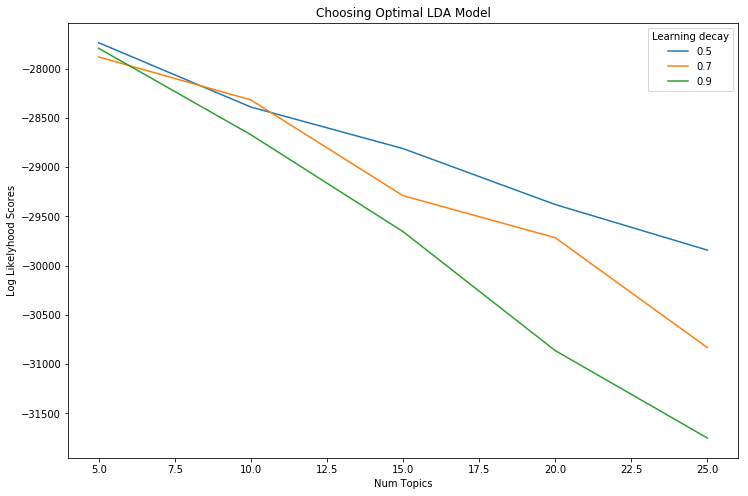

In [33]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [5,10, 15, 20, 25]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()